In [2]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt


In [3]:
arr = np.loadtxt("Classification_train.csv", skiprows = 1, delimiter=",")
arr1 = np.random.permutation(arr)
# X=arr.drop(['label'],axis=1)
# Y=arr['label']


In [4]:
x_train1=arr1[:,1:]
y_train1=arr1[:,0]



In [5]:
X_train=np.array(x_train1[:24000],dtype="float64")
Y_train=np.array(y_train1[:24000],dtype="int32")
X_test=np.array(x_train1[24000:],dtype="float64")
Y_test=np.array(y_train1[24000:],dtype="int32")



In [6]:
def normalise(x):
    """
    x= array(m,n) = trainig set m= no of examples, n= no.of features
    mu (ndarray (n,))     : mean of each feature
        sigma (ndarray (n,))  : standard deviation of each feature
    """
    n=np.shape(x[1:][0])
    mu = np.mean(x, axis=0)
    sigma = np.std(x, axis=0)+1e-10
    x_normalised= (x-mu)/sigma
    return x_normalised,mu,sigma

In [7]:
# @title relu
def relu(z):
    return np.maximum(0,z)    

In [8]:
def softmax(z):
    """
    x: array of outputs of each previous neuron(shape = (m,n))
    w: array(10,n): weight for each number
    b:array(10,1):bias for each number
    """

    z_max=np.max(z, axis=1, keepdims=True)
    exponential= np.exp(z-z_max)  #shape(m,10)
    denominator=np.sum(exponential,0) + 1e-15  #shape(m,)
   
    return np.divide(exponential,denominator).T #shape(m,10)

In [9]:
def cost(y_one_hot, softmax_output,_lambda,w_s):
    
    m=y_one_hot.T.shape[0]

    cost = -np.sum(y_one_hot * np.log(softmax_output))/m

    regularization= _lambda*np.sum(np.square(w_s))
    regularization=regularization/(2*m)

    total_cost=cost+regularization

    return total_cost

In [10]:
def one_hot_encoding(y):
    m=y.size
    n=10
    p=np.zeros((m,n))
    p[np.arange(m),y]=1
    return p.T

In [11]:
def relu_derivative(z):
    return np.where(z> 0, 1, 0)

In [12]:
def softmax_grad(y,x_l,soft):
    """
    y:array(m,):output labels
    x_l:(n,):activationof last hidden layer
    w_s(10,n):weights of softmax
    b_s:(10,):bias of softmax
    """    
    m=y.shape[0]
    
    y_one_hot=one_hot_encoding(y)
    dw_s=np.dot((soft - y_one_hot), x_l)/m
    #print(soft.shape)
    db_s=np.sum((soft-y_one_hot).T,axis=0)/m
    return dw_s,db_s

In [13]:
def last_r_grad(y,soft,x_prev,w_s,z,w_l):
    """ 
    soft:(m,10):output of softmax
    z:pre activation output of last output layer
    x_prev:activation of second lst hidden layer
    w_l: wights of last laer
    """
    m=y.shape[0]
    
    y_one_hot=one_hot_encoding(y)
    
    dw_l=np.dot((np.dot((soft-y_one_hot).T,w_s)*relu_derivative(z)).T,x_prev)/m
    db_l=np.sum((np.dot((soft-y_one_hot).T,w_s)*relu_derivative(z)),axis=0,keepdims=True)/m
    dc_dx_l_1=np.dot((np.dot((soft-y_one_hot).T,w_s)*relu_derivative(z)),w_l)/m #derivative of cost wrt pre activaton of previous layer
    return dw_l,db_l,dc_dx_l_1

In [14]:
def relu_grad(x_prev,z,dc_dzn,w):
    """ 
    w=weights of curent layer
    x_prev=activation of previous layer
    z=pre activationoutput of current layer
    dc_dzn=derivative of cost wrt pre activaton of current layer
    """
    m=x_prev.size
    dw=np.dot((dc_dzn*relu_derivative(z)).T,x_prev)
    db=np.sum((dc_dzn*relu_derivative(z)),axis=0,keepdims=True)
    dc_dxn=np.dot((dc_dzn*relu_derivative(z)),w)
    return dw,db,dc_dxn

In [15]:
def adam_initialise(layers):
    weight = []
    bias = []
    n = len(layers)
    for i in range(n):
        if i == 0:
            weight.append(np.zeros((layers[0], 784)))
            bias.append(np.zeros((layers[0]),))
        else:
            weight.append(np.zeros((layers[i], layers[i - 1])))
            bias.append(np.zeros((layers[i]),))

    weight.append(np.zeros((10, layers[-1])))
    bias.append(np.zeros(10,))

    return weight, bias

In [16]:
def gradient_descent(weight, bias, grad_w, grad_b, Vdw, Vdb, Sdw, Sdb, beta_1, beta_2,alpha, layers):
    n = len(weight)

    for i in range(n):
        
        Vdw[i] = beta_1 * Vdw[i] + (1 - beta_1) * grad_w[n-1-i]
        Vdb[i] = beta_1 * Vdb[i] + (1 - beta_1) * grad_b[n-1-i]
        Sdw[i] = beta_2 * Sdw[i] + (1 - beta_2) * np.square(grad_w[n-1-i])
        Sdb[i] = beta_2 * Sdb[i] + (1 - beta_2) * np.square(grad_b[n-1-i])
        weight[i] -= alpha * (Vdw[i] / np.sqrt(Sdw[i] + np.finfo(np.float64).eps))
        bias[i] -= alpha * (Vdb[i] / np.sqrt(Sdb[i] + np.finfo(np.float64).eps)).squeeze()



    return weight, bias, Vdw, Vdb,Sdw,Sdb

In [17]:
def initial_weight_n_bias(layers):
    weight=[]
    bias=[]
    n=len(layers)
    for i in range(n):
        if i==0:
            weight.append(np.random.randn(layers[0],784)*np.sqrt(2/784))
            bias.append(np.random.randn(layers[0])*np.sqrt(2/784)) 
        else:
            weight.append(np.random.randn(layers[i],layers[i-1])*np.sqrt(2/layers[i-1]))
            bias.append(np.random.randn(layers[i])*np.sqrt(2/layers[i-1]))
    
    weight.append(np.random.randn(10,layers[-1])*np.sqrt(2/layers[-1]))
    bias.append(np.random.randn(10,)*np.sqrt(2/layers[-1]))

    return weight,bias

In [18]:
def forward_prop(layers,x,w,b):
    n=len(layers) #number of hidden layers
    forward_values=[]
    pre_act=[]
    forward_values.append(x)
    for i in range(n):
                
        z=np.dot(x,w[i].T) + b[i]
        pre_act.append(z)
        x=relu(z)
        forward_values.append(x)
    z=np.dot(x,w[-1].T)+b[-1]
    
    soft = softmax(z)
    
    forward_values.append(soft)
    return forward_values,pre_act

In [19]:
def back_pass(layers,y,forward_values,pre_act,weights):#correction ramoaing in for loop for i=n-1
    n=len(layers)
    grad_w=[]
    grad_b=[]
    dw_s,db_s=softmax_grad(y,forward_values[-2],forward_values[-1])
    grad_w.append(dw_s)
    grad_b.append(db_s)
    
    dw_l,db_l,dc_dxn=last_r_grad(y,forward_values[-1],forward_values[-3],weights[-1],pre_act[-1],weights[-2])

    grad_w.append(dw_l)
    grad_b.append(db_l)
    for i in range(n-1):
        dw,db,dc_dxn=relu_grad(forward_values[-4-i],pre_act[-2-i],dc_dxn,weights[-3-i])
        grad_w.append(dw)
        grad_b.append(db)
    
    return grad_w,grad_b

In [20]:
def neural(x, y, layers, itr_nos, alpha, beta_1, beta_2, _lambda=0):
    n = len(layers)
    m,n=x.shape
    weight, bias = initial_weight_n_bias(layers)
    Vdw, Vdb = adam_initialise(layers)
    Sdw, Sdb = adam_initialise(layers)
    y_one_hot = one_hot_encoding(Y_train)
    batch=128
    k=m//batch
    C_hist=np.zeros(itr_nos)
    for i in range(itr_nos):
        for j in range(k):
            x_t=x[batch*j:batch*(j+1)]
            y_t=y[batch*j:batch*(j+1)]
            forward_values, pre_act = forward_prop(layers, x_t, weight, bias)
            grad_w, grad_b = back_pass(layers, y_t, forward_values, pre_act, weight)
            weight, bias, Vdw, Vdb ,Sdw,Sdb= gradient_descent(weight, bias, grad_w, grad_b, Vdw, Vdb, Sdw, Sdb, beta_1, beta_2,
                                                 alpha, layers)
        # if i % math.ceil(itr_nos / 5) == 0:
        #     alpha=alpha*0.5
        
        forward_values_c, pre_act = forward_prop(layers, x, weight, bias)
        costn=cost(y_one_hot, forward_values_c[-1], _lambda, weight[-1])
        C_hist[i]+=costn
        if i % math.ceil(itr_nos / 10) == 0:
            print(f"epoch={i}, cost={costn}")
    return weight, bias,C_hist

In [24]:
layers=[512,324]
x_norm,mu,sigma=normalise(X_train)
weight,bias,C_hist=neural(x_norm,Y_train,layers,100,0.0000003,0.7,0.999)

epoch=0, cost=10.514434831010352
epoch=10, cost=9.997817005474616
epoch=20, cost=9.679732420692464
epoch=30, cost=9.439324911123206
epoch=40, cost=9.25321548711068
epoch=50, cost=9.10540962400596
epoch=60, cost=8.986859423672923
epoch=70, cost=8.89270478727913
epoch=80, cost=8.81888647882679
epoch=90, cost=8.762589898319876


In [25]:
X_test_n=(X_test-mu)/sigma
ford,pre=forward_prop(layers,X_test/255,weight,bias)
pred=np.argmax(ford[-1],axis=0)
def accuracy(y1,y2):
    return np.mean(y1==y2)
print(f"accuracy:{accuracy(Y_test,pred)}")

accuracy:0.798


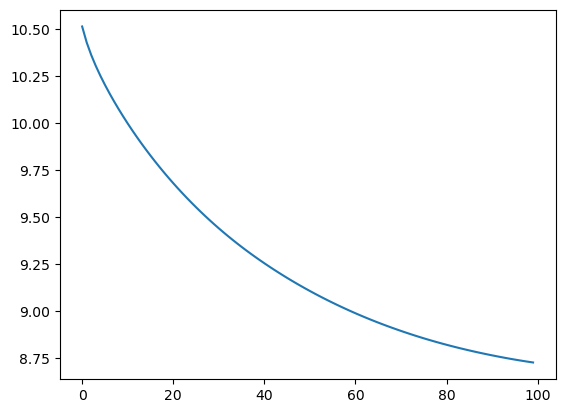

In [26]:
plt.plot(C_hist)
plt.show()